# TP4 Neural Networks

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework)

## 0. A simple MLP implementation

As always some useful imports:

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['image.cmap'] = 'gray' 
import scipy.ndimage as ndimage
import scipy.optimize as optimize

import os

try:
    # tqdm is a very useful library to monitor the progression of your loops
    # (not necessary but handy)
    from tqdm.notebook import tqdm
except ImportError:
    pass

We will consider a Neural Network as a modular architecture, all layer and loss being a `Module`. We define the `Linear`, `ReLU` layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the least square loss function, `LeastSquareCriterion`.

In [121]:
class Module(object):
    def __init__(self):
        self.gradInput = None 
        self.output = None
        
    def forward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError


class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes = num_classes
    
    def forward(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1
        self.output = np.sum((target-x)**2, axis=1)
        return np.mean(self.output)
    
    def backward(self, x, labels):
        self.gradInput = x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]] = x[i, labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = (
            math.sqrt(1. / (out_features*in_features)) * 
            np.random.randn(out_features, in_features)
        )
        self.bias = np.zeros(out_features)
        
        self.gradWeight = None
        self.gradBias = None
    

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput
    
    """def gradientStep(self, lr):
        self.weight = self.weight - lr*self.gradWeight
        self.bias = self.bias - lr*self.gradBias"""
    
    def gradientStep(self,lr, weight_decay=0):
        self.weight=self.weight-lr*(self.gradWeight+weight_decay*self.weight)
        self.bias=self.bias-lr*self.gradBias
    
class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output = x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = (x>0) * gradOutput
        return self.gradInput
    def gradientStep(self, lr):
        pass


class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10, hidden_dim = 64): #Question 2 
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_dim)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

## 1. Training a neural network

To train a network, we will need data. Download the Mini-MNIST data (on Moodle) (~4Mo). I consists of 28×28 images (loaded as vectors of size 784) and the associated label for training and test sets.

5


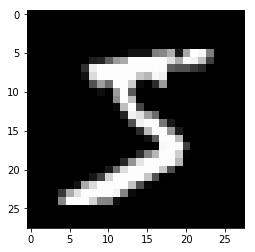

In [63]:
data = np.load("mini_mnist.npz")

train_data = data["train_data"]
train_labels = data["train_labels"]
test_data = data["test_data"]
test_labels = data["test_labels"]

N_train = train_data.shape[0]
N_test = test_data.shape[0]

# Check that data makes sense
plt.figure()
plt.imshow(train_data[0, :].reshape(28,28))
print(train_labels[0])
plt.show()

Read and understand the code provided above

**1.a.** Write a function `train_iter(model, loss, batch_data, batch_labels, lr)` that trains one iteration of a given `model` and `loss` (subclasses of `Module`) on a batch `(batch_data, batch_labels)` with a learning rate `lr`, and returns the training loss value. <br/>
**b.** Test your function: write a simple loop that trains for 50 iterations a `SimpleMLP` on `train_data` with a learning rate `1e-3` and batches of size `16`.

*Note: An **iteration** consists in running one batch through the model; an **epoch** consists in running multiple iterations so as to process each example of the training set once.*

In [64]:
#Question 1a

def train_iter(model, loss, batch_data, batch_labels, lr):
    
    x = model.forward(batch_data)
    grad_loss = loss.backward(x, batch_labels)
    model.backward(batch_data, grad_loss)
    model.gradientStep(lr)
    return loss.forward(x, batch_labels)

#Question 1b
lr = 1e-3
batch_size = 16
iterations = 50
model = SimpleMLP()
loss = LeastSquareCriterion()


for _ in range(iterations):
    j = np.random.randint(len(train_data), size = batch_size)
    batch_data, batch_labels = train_data[j,:], train_labels[j]
    train_iter(model, loss, batch_data, batch_labels, lr)
    

**2.a.** Write a function `evaluate(model, loss, data, labels)` that returns a couple `(loss, accuracy)` corresponding to the loss and accuracy computed on the whole `data`. <br/>
**b.** Use your function to evaluate the model trained in question **1.b.** on the training and testing data. <br/> 
**c.** Check visually the quality of the results by plotting a few examples and their predictions.

loss_train = 0.8215806634108809, accuracy_train = 0.4677
loss_test = 0.8331667001503321, accuracy_test = 0.456


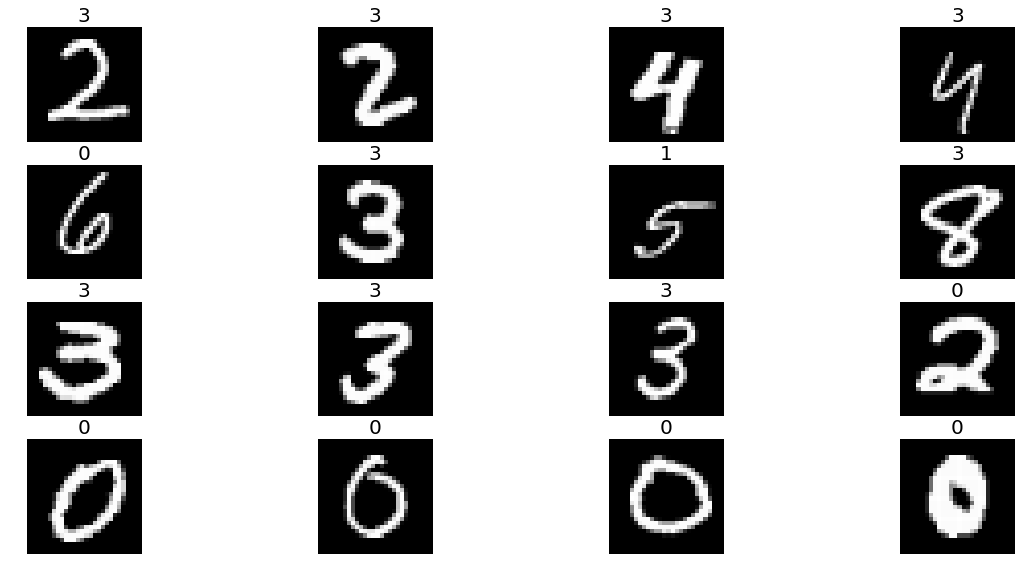

In [65]:
# Question 2.a
def evaluate(model, loss, data, labels):
    x = model.forward(data)
    lvalue = loss.forward(x, labels)
    return lvalue, sum(np.argmax(x,axis=1) == labels)/len(labels)

#Question 2.b
ltrain, atrain = evaluate(model, loss, train_data, train_labels)
ltest, atest = evaluate(model, loss, test_data, test_labels)
print('loss_train = {}, accuracy_train = {}'.format(ltrain, atrain))
print('loss_test = {}, accuracy_test = {}'.format(ltest, atest))

#Question 2.c

def show_img(model, train_data, train_labels, batch_size):
    rand_sample = np.random.randint(len(train_data), size=batch_size)

    fig = plt.figure(figsize = (20., 40.))
    for i, n in enumerate(rand_sample):
        x_data = train_data[n, :].reshape(28, 28)
        y_label = train_labels[n]
        predicted_label = np.argmax(model.forward(train_data[n, :]))
        plt.subplot(16, 4, i+1)
        plt.title(str(predicted_label), fontsize=20)
        plt.axis('off')
        plt.imshow(x_data)
    plt.show()

show_img(model, train_data, train_labels, batch_size)

## Comment: 
* The loss is very high and the accuracy is very low which means that the model has predicted wrong labels for many of the images. The behaviour is to be expected since we train our model for only 50 iterations.

**3.** Write a loop that trains a `SimpleMLP` for a whole epoch with the same parameters as in question **1.a.**. Plot the training and testing losses and accuracies during this training. 

*Note: you don't have to evaluate your network at every iteration, you can for example do it every 10 iterations*

In [66]:
#Question 3a
lr = 1e-3
batch_size = 16
model = SimpleMLP()
loss = LeastSquareCriterion()

ltrain , atrain = [] , []
ltest, atest = [] , []

counter = 0
for i in range(0, len(train_labels), batch_size):
    batch_data, batch_labels = train_data[i:i+batch_size, :], train_labels[i:i+batch_size]
    train_iter(model, loss, batch_data, batch_labels, lr)
    counter += 1
    if counter%10 == 0:
        l, a = evaluate(model, loss, train_data, train_labels)
        ltrain.append(l)
        atrain.append(a)
        l, a = evaluate(model, loss, test_data, test_labels)
        ltest.append(l)
        atest.append(a)

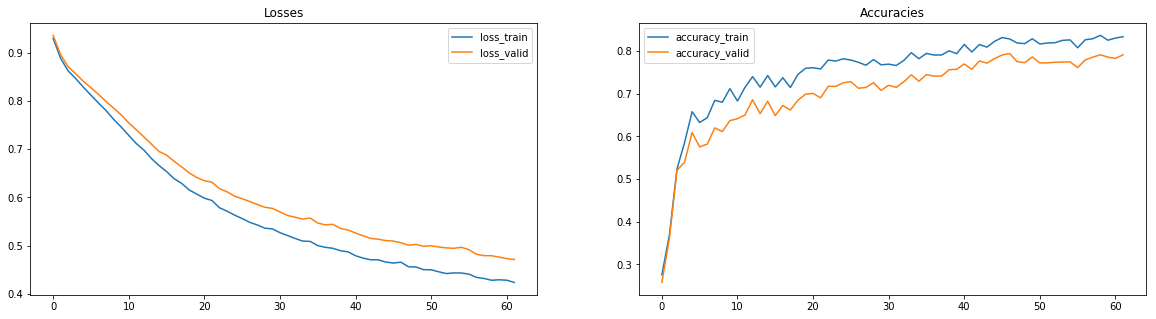

In [94]:
#Plot
def plot(ltrain, ltest, atrain, atest):
    plt.subplot(1,2,1)
    plt.plot(ltrain, label="loss_train")
    plt.plot(ltest, label="loss_valid")
    plt.title("Losses")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(atrain, label="accuracy_train")
    plt.plot(atest, label="accuracy_valid")
    plt.legend()
    plt.title("Accuracies")
    plt.show()

plt.figure(figsize=(20,5))
plot(ltrain, ltest, atrain, atest)
plt.show()

**4.a.** Based on the previous questions, design a function 

<center><pre>train(model, loss, train_data, train_labels, test_data, test_labels, ...)</pre></center>

that performs a full training of the input `model` on the training data. Choose the arguments of your function (for instance, `batch_size`, `lr`, `epochs`, etc) according to what seems relevant to you. This function should plot the training and validation losses and accuracies during training. <br/>
**b.** Use your function to train a model with a good accuracy (decide for a learning rate, batch size...)

In [108]:
#Question 4.a

# train function that plots the train/test loss and accuracy at every epoch
def train_with_plot(model, loss, train_data, train_labels, test_data, test_labels, batch_size, lr, nb_epochs):
    for epoch in range(nb_epochs):
        plt.figure(figsize=(20,5))
        print("Epoch ({}/{})..".format(epoch+1, nb_epochs))
        ltrain , atrain, ltest, atest = [] , [], [], []
        counter = 0
        for i in range(0, len(train_labels), batch_size):
            batch_data, batch_labels = train_data[i:i+batch_size, :], train_labels[i:i+batch_size]
            train_iter(model, loss, batch_data, batch_labels, lr)
            counter += 1
            if counter%10 == 0:
                l, a = evaluate(model, loss, train_data, train_labels)
                ltrain.append(l)
                atrain.append(a)
                l, a = evaluate(model, loss, test_data, test_labels)
                ltest.append(l)
                atest.append(a)
        plot(ltrain, ltest, atrain, atest)
    return ltrain, ltest, atrain, atest

# train function that prints the last train/test loss and accuracy value at every epoch
def train_with_print(model, loss, train_data, train_labels, test_data, test_labels, batch_size, lr, nb_epochs, printing=True):
    print("Training model...")
    for epoch in range(nb_epochs):
        ltrain , atrain, ltest, atest = [] , [], [], []
        counter = 0
        for i in range(0, len(train_labels), batch_size):
            batch_data, batch_labels = train_data[i:i+batch_size, :], train_labels[i:i+batch_size]
            train_iter(model, loss, batch_data, batch_labels, lr)
            counter += 1
            if counter%10 == 0:
                l, a = evaluate(model, loss, train_data, train_labels)
                ltrain.append(l)
                atrain.append(a)
                l, a = evaluate(model, loss, test_data, test_labels)
                ltest.append(l)
                atest.append(a)
        print("Epoch ({}/{}): train_loss = {}, train_acc = {}, test_loss = {}, test_acc = {}".format(epoch+1, nb_epochs, \
                                                                                                     ltrain[-1], atrain[-1], \
                                                                                                      ltest[-1], atest[-1] ))
    print("End Train")
    return ltrain, ltest, atrain, atest


Epoch (1/10)..


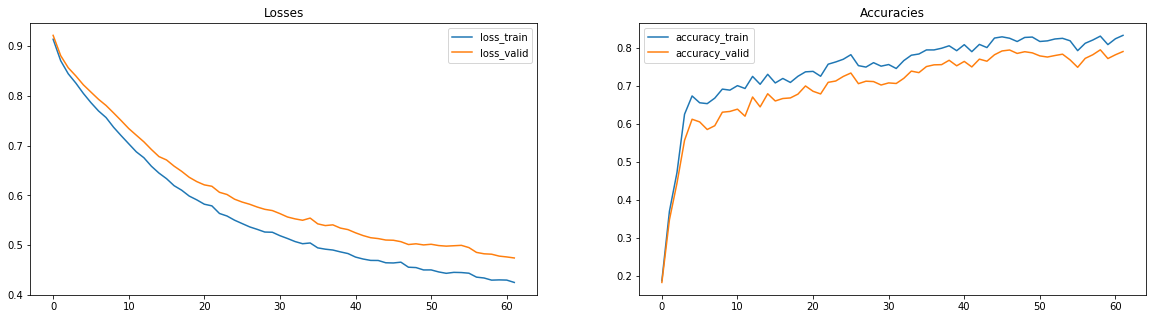

Epoch (2/10)..


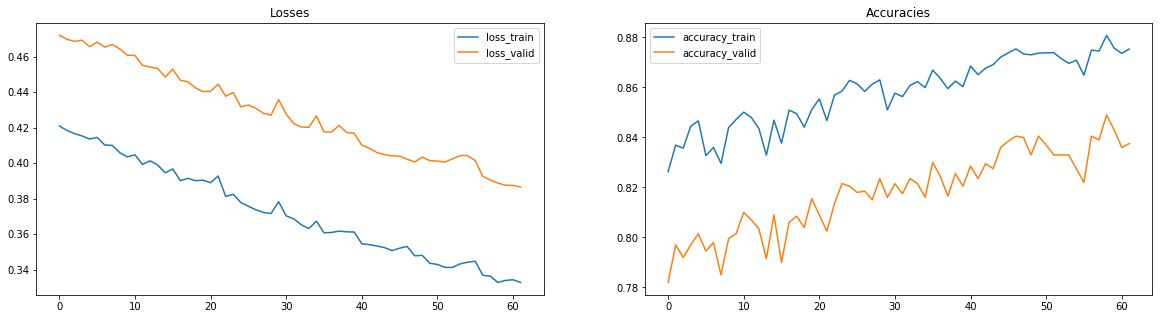

Epoch (3/10)..


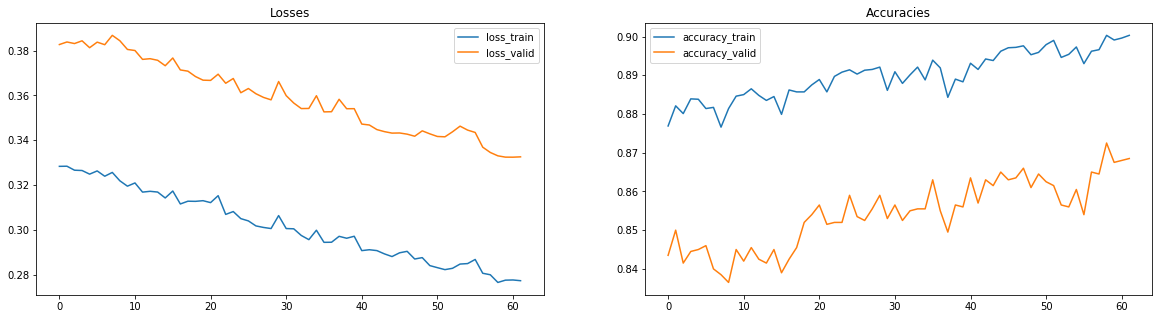

Epoch (4/10)..


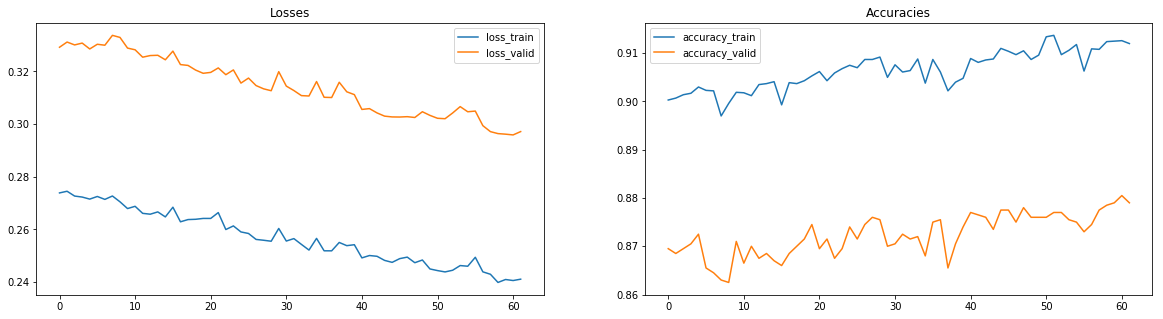

Epoch (5/10)..


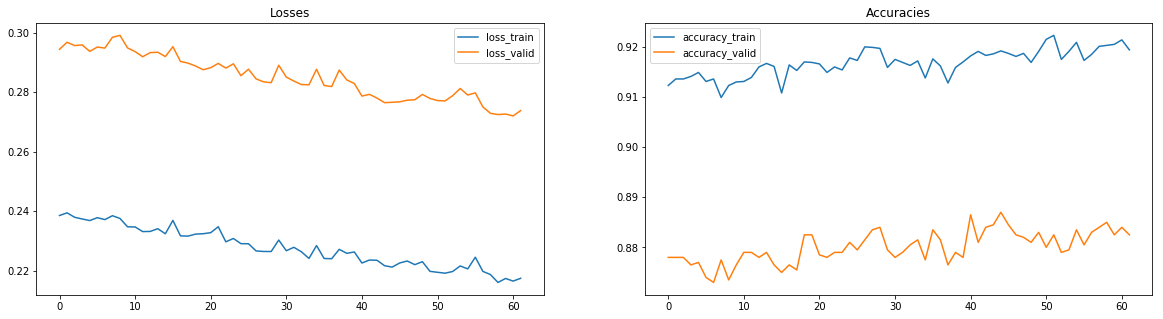

Epoch (6/10)..


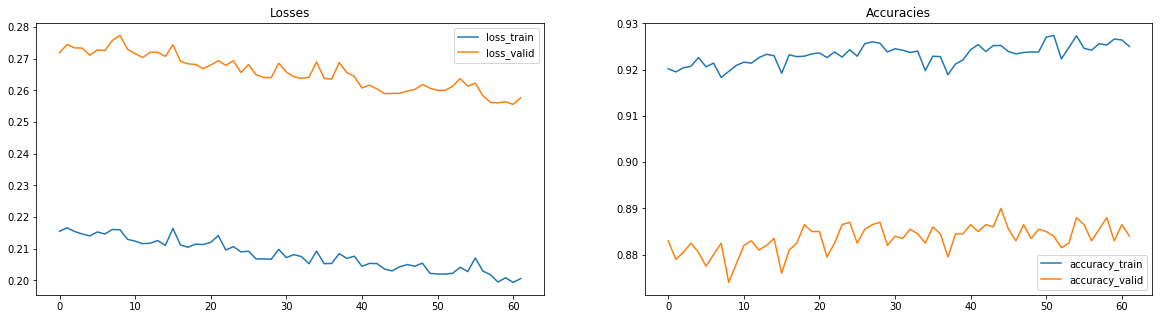

Epoch (7/10)..


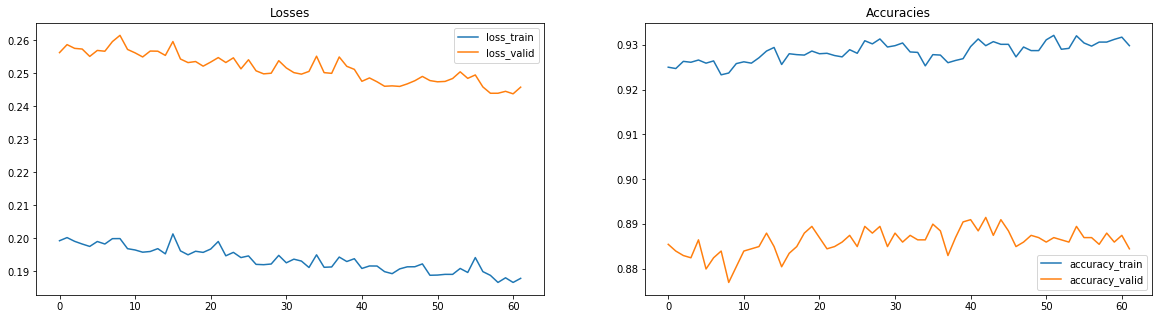

Epoch (8/10)..


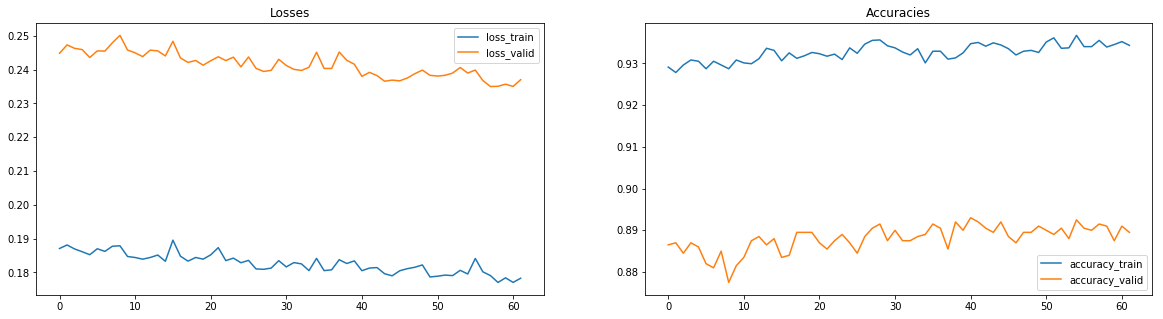

Epoch (9/10)..


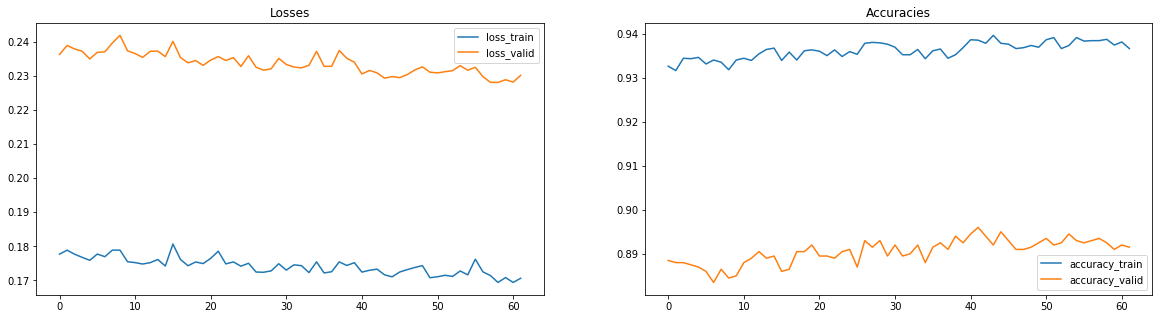

Epoch (10/10)..


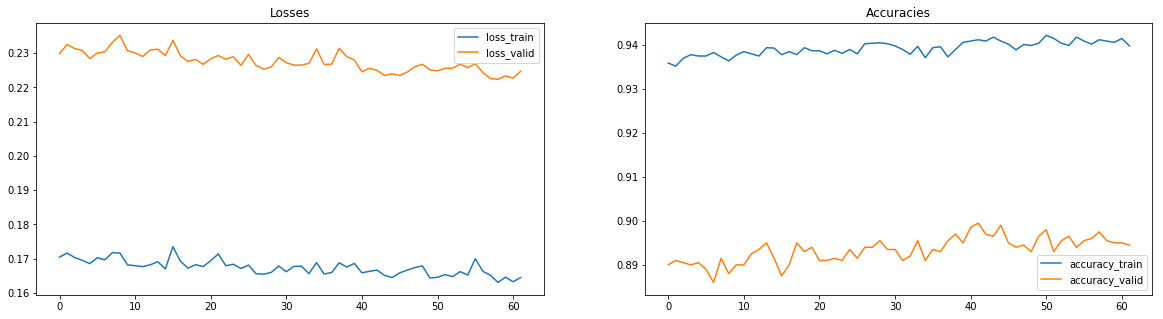

In [104]:
#Question 4.b
lr = 1e-3
batch_size = 16
nb_epochs = 10

model = SimpleMLP()
loss = LeastSquareCriterion()

ltr, lts, atr, atst = train_with_plot(model, loss, train_data, train_labels, test_data, test_labels, \
                                      batch_size, lr, nb_epochs)

Train: loss = 0.16451621638807473, accuracy = 0.9398
Test:  loss = 0.22474214177750856, accuracy = 0.8945


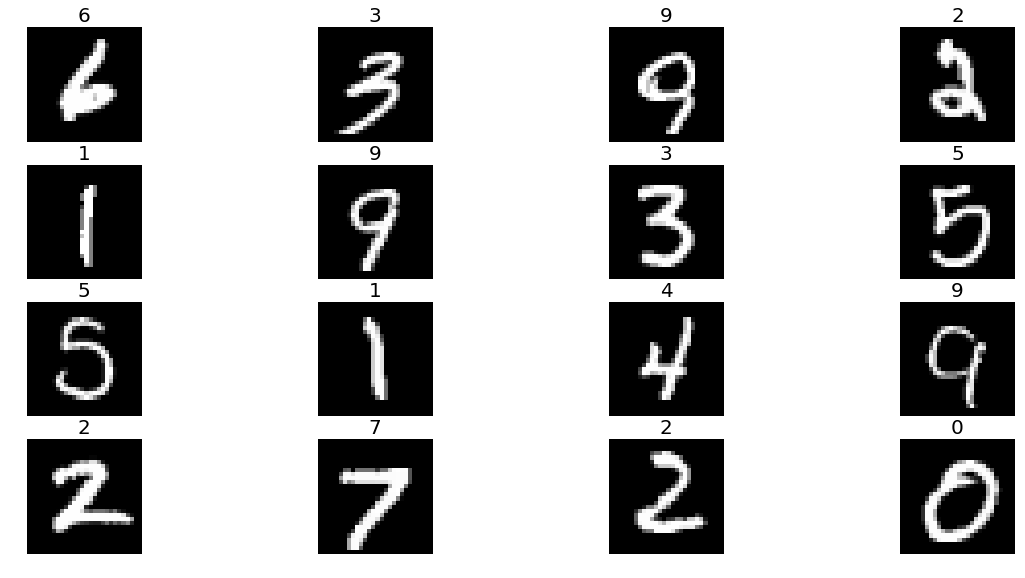

In [105]:
#Printing
print("Train: loss = {}, accuracy = {}".format(ltr[-1], atr[-1]))
print("Test:  loss = {}, accuracy = {}".format(lts[-1], atst[-1]))

show_img(model, train_data, train_labels, batch_size)

## Comment:
* The prediction of labels is much more accurate this time than previously.

## 2. Overfitting

**1.** What's the number of parameters in the network `SimpleMLP` used in the first section?

There are 2 layers who have parameters `fc1 , fc2` and one ReLu layer which doesn't have parameters. `fc1` has $784\times 64$ weights and `fc2` has $64 \times 10$ weights which in total ammounts to $32112640$ parameters.

**2.a.** Modify the definition of `SimpleMLP` to allow changing the dimension of the hidden layer. <br/>
**b.** Define a class `DoubleMLP` with three `Linear` layers, and parameters to change their dimensions. <br/>
**c. (optional)** Define a class `DeepMLP` with a **list** parameter `hidden_features` that allows to vary the number of intermediate linear layers, and their dimensions:

- `DeepMLP([64])` should be equivalent to `SimpleMLP()`;
- `DeepMLP([64, 64, 64])` should be a MLP with four linear layers...

**d.** Test your new classes: train a `DoubleMLP(64, 32)` and plot its performance

In [109]:
#Question 2.a
# changed the __init__() method of SimpleMLP class.
#Question 2.b
class DoubleMLP(Module):
    """
    This class is another example of a neural network, composed of 3
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10, hidden_dim = (64,64)):
        super(DoubleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_dim[0])
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = Linear(hidden_dim[1], num_classes)
        
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

#Question 2.c
class DeepMLP(Module):
    """
    This class is another example of a neural network, composed of many
    linear layers, with a ReLU non-linearity in the middle of each linear 
    layer
    """
    def __init__(self, in_dimension=784, num_classes=10, hidden_features = [64]):
        super(DeepMLP, self).__init__()
    
        self.layers = [Linear(in_dimension, hidden_features[0]), ReLU()]
        for i in range(len(hidden_features)-1):
            self.layers.append(Linear(hidden_features[i], hidden_features[i+1]))
        self.layers.append(Linear(hidden_features[-1], num_classes))
        

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, x, gradient):
        backlayers = list(reversed(self.layers))
        for i in range(len(self.layers)-1):
            gradient = backlayers[i].backward(backlayers[i+1].output, gradient)
        gradient = backlayers[-1].backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        for layer in reversed(self.layers):
            layer.gradientStep(lr)
        return True


In [110]:
#Question 2.d testing with DoubleMLP

lr = 1e-3
batch_size = 16
nb_epochs = 10

model = DoubleMLP(hidden_dim=(64, 32))
loss = LeastSquareCriterion()

ltr, lts, atr, atst = train_with_print(model, loss, train_data, train_labels, test_data, test_labels,\
                                       batch_size, lr, nb_epochs)

Training model...
Epoch (1/10): train_loss = 0.7720606137586715, train_acc = 0.5923, test_loss = 0.7863883460739192, test_acc = 0.5675
Epoch (2/10): train_loss = 0.5642146364357931, train_acc = 0.7047, test_loss = 0.6004741985020791, test_acc = 0.6555
Epoch (3/10): train_loss = 0.4780334967004609, train_acc = 0.7779, test_loss = 0.5194950512724364, test_acc = 0.734
Epoch (4/10): train_loss = 0.399084875076272, train_acc = 0.8294, test_loss = 0.4457617985909383, test_acc = 0.784
Epoch (5/10): train_loss = 0.3353837465132807, train_acc = 0.863, test_loss = 0.3891649938937295, test_acc = 0.807
Epoch (6/10): train_loss = 0.28998343000066906, train_acc = 0.8821, test_loss = 0.34787592251603816, test_acc = 0.8325
Epoch (7/10): train_loss = 0.2573062143993653, train_acc = 0.8975, test_loss = 0.31636549620712695, test_acc = 0.8565
Epoch (8/10): train_loss = 0.23407618944599534, train_acc = 0.9077, test_loss = 0.2932781342378954, test_acc = 0.8675
Epoch (9/10): train_loss = 0.21691969369900316,

Train: loss = 0.20375519435298192, accuracy = 0.9214
Test:  loss = 0.26362555573111274, accuracy = 0.8775


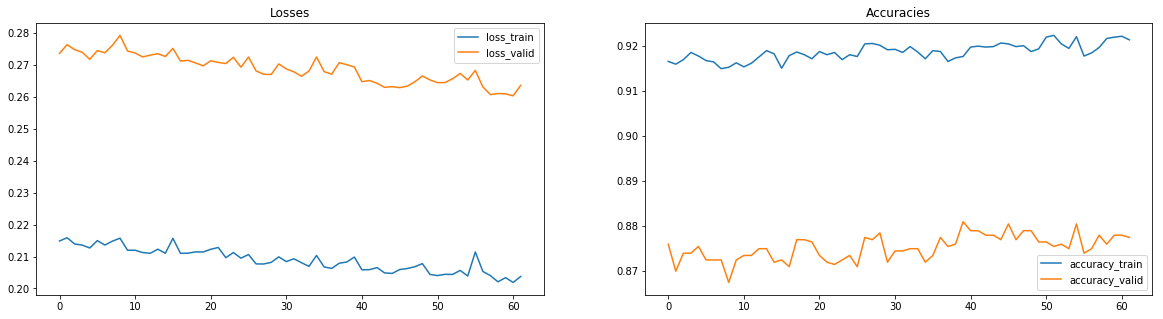

In [111]:
#Question  2.d testing with DoubleMLP
print("Train: loss = {}, accuracy = {}".format(ltr[-1], atr[-1]))
print("Test:  loss = {}, accuracy = {}".format(lts[-1], atst[-1]))

#show_img(model, test_data, test_labels, batch_size)
plt.figure(figsize=(20,5))
plot(ltr, lts, atr, atst)

In [112]:
#Question 2.c + 2.d TESTING with DeepMLP
lr = 1e-3
batch_size = 16
nb_epochs = 10

model = DeepMLP(hidden_features=[64, 32])
loss = LeastSquareCriterion()

ltr, lts, atr, atst = train_with_print(model, loss, train_data, train_labels, test_data, test_labels, \
                                       batch_size, lr, nb_epochs)

Training model...
Epoch (1/10): train_loss = 0.7696654598489424, train_acc = 0.535, test_loss = 0.784989889860005, test_acc = 0.4855
Epoch (2/10): train_loss = 0.5771506749585309, train_acc = 0.6492, test_loss = 0.6092600499017664, test_acc = 0.616
Epoch (3/10): train_loss = 0.4671368155125127, train_acc = 0.736, test_loss = 0.5058829317615241, test_acc = 0.696
Epoch (4/10): train_loss = 0.39850647406864453, train_acc = 0.7803, test_loss = 0.4426174807921893, test_acc = 0.7405
Epoch (5/10): train_loss = 0.34331350712339065, train_acc = 0.8393, test_loss = 0.39259422947587025, test_acc = 0.791
Epoch (6/10): train_loss = 0.293427412778757, train_acc = 0.8846, test_loss = 0.34729340331062164, test_acc = 0.8385
Epoch (7/10): train_loss = 0.2563481921749631, train_acc = 0.9035, test_loss = 0.31268926455818885, test_acc = 0.862
Epoch (8/10): train_loss = 0.2320731601587539, train_acc = 0.912, test_loss = 0.28937092370068934, test_acc = 0.8685
Epoch (9/10): train_loss = 0.21572105623488327, t

Train: loss = 0.20373799987441224, accuracy = 0.9206
Test:  loss = 0.2632344975117904, accuracy = 0.878


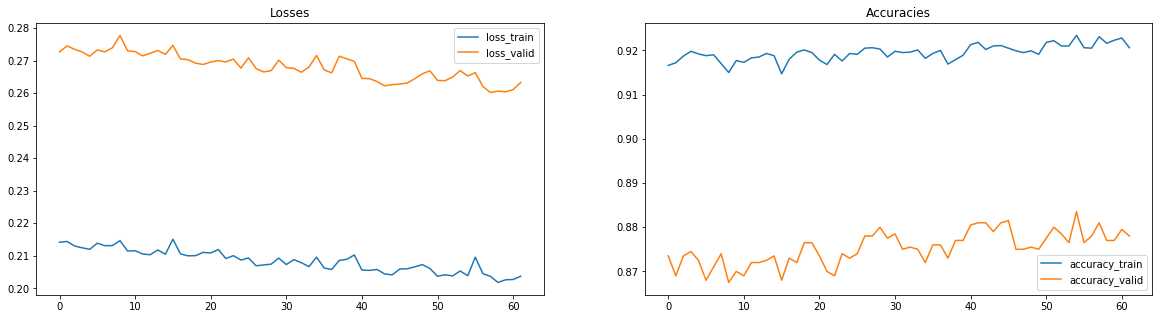

In [114]:
print("Train: loss = {}, accuracy = {}".format(ltr[-1], atr[-1]))
print("Test:  loss = {}, accuracy = {}".format(lts[-1], atst[-1]))

#show_img(model, test_data, test_labels, batch_size)
plt.figure(figsize=(20,5))
plot(ltr, lts, atr, atst)

Test different sizes of networks and layers. <br/> 
**3.a.** Find a set of parameters and hyperparameters that shows strong evidence of overfitting. <br/>
**b.** What's the number of parameters of this network? Why does it overfit?

In [115]:
#Question 3.a

lr = 1e-3
batch_size = 16
nb_epochs = 60

model = DoubleMLP(hidden_dim=(200,200))
loss = LeastSquareCriterion()

ltr, lts, atr, atst = train_with_print(model, loss, train_data, train_labels, test_data, test_labels,\
                            batch_size, lr, nb_epochs, printing)


Training model...
Epoch (1/60): train_loss = 0.8738856205121424, train_acc = 0.4423, test_loss = 0.8772068510135557, test_acc = 0.4295
Epoch (2/60): train_loss = 0.6735324504313245, train_acc = 0.5578, test_loss = 0.696882601839827, test_acc = 0.512
Epoch (3/60): train_loss = 0.5464298330668255, train_acc = 0.7139, test_loss = 0.5792929773171716, test_acc = 0.686
Epoch (4/60): train_loss = 0.445259180557717, train_acc = 0.7783, test_loss = 0.48562214709696133, test_acc = 0.734
Epoch (5/60): train_loss = 0.37719232193420577, train_acc = 0.8186, test_loss = 0.4234455104647979, test_acc = 0.7665
Epoch (6/60): train_loss = 0.31961380653242866, train_acc = 0.8728, test_loss = 0.37035110472948485, test_acc = 0.8245
Epoch (7/60): train_loss = 0.2696696092818335, train_acc = 0.8987, test_loss = 0.3238882768388123, test_acc = 0.8585
Epoch (8/60): train_loss = 0.2362467448084054, train_acc = 0.909, test_loss = 0.2917349925338431, test_acc = 0.8715
Epoch (9/60): train_loss = 0.2153348550095763, t

### Comment : Question 3.b
As we can see above the network is clearly overfitting the training data as we obtain an accuracy value very close to 99% whereas for the validation data that value is ...

Train: loss = 0.0632491542802534, accuracy = 0.9919
Test:  loss = 0.14598982816200579, accuracy = 0.9465


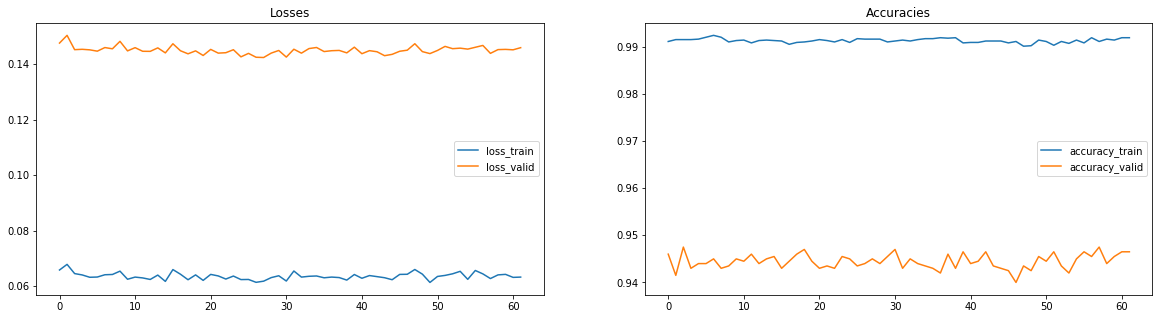

In [116]:
print("Train: loss = {}, accuracy = {}".format(ltr[-1], atr[-1]))
print("Test:  loss = {}, accuracy = {}".format(lts[-1], atst[-1]))

#show_img(model, test_data, test_labels, batch_size)
plt.figure(figsize=(20,5))
plot(ltr, lts, atr, atst)

**4.** Add to `Linear` and one of your MLP classes an optional parameter for (L2) weight decay (in the `gradientStep` functions) and show that it can reduce overfitting in some cases.

*(Note: improving the validation performance may be hard; you can look at a setting with only very little training data to see, and focus on showing that the gap between training and validation performance decreases)*

In [133]:
#Question 4

# UN-COMMENT in the Linear class the function gradientStep(lr, weight_decay).

class DoubleMLP_decay(Module):
    """
    This class is another example of a neural network, composed of 3
    linear layers, with a ReLU non-linearity in the middle. Weight_Decay
    """
    def __init__(self, in_dimension=784, num_classes=10, hidden_dim = (64,64), weight_decays=(0,0,0)):
        super(DoubleMLP_decay, self).__init__()
        self.weight_decays = weight_decays
        self.fc1 = Linear(in_dimension, hidden_dim[0])
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = Linear(hidden_dim[1], num_classes)
        
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc3.gradientStep(lr, weight_decays[0])
        self.fc2.gradientStep(lr, weight_decays[1])
        self.fc1.gradientStep(lr, weight_decays[2])
        return True
        

In [135]:
# Testing
lr = 1e-3
batch_size = 16
nb_epochs = 60

model = DoubleMLP_decay(hidden_dim=(128, 128), weight_decays=(1, 1, 0.1))
loss = LeastSquareCriterion()

ltr, lts, atr, atst = train_with_print(model, loss, train_data, train_labels, test_data, test_labels,\
                            batch_size, lr, nb_epochs)


Training model...


NameError: name 'weight_decays' is not defined

In [ ]:
print("Train: loss = {}, accuracy = {}".format(ltr[-1], atr[-1]))
print("Test:  loss = {}, accuracy = {}".format(lts[-1], atst[-1]))

#show_img(model, test_data, test_labels, batch_size)
plt.figure(figsize=(20,5))
plot(ltr, lts, atr, atst)

## 3. Optional

The following questions are optional and do not have a specific order! A limited number of bonus points can be granted on completing them.

**1.** Implement and test different non-linearities

**2.** Implement and test different loss functions (L1, Cross-Entropy)

**3.** Add some momentum to your training procedure. How does it change the training behavior?

**4.** (longer/harder) Implement and test layers that consider the 2D structure of the input data (max pooling, convolution)